In [1]:
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import andes
import ams

import warnings

warnings.filterwarnings("ignore", category=np.ComplexWarning)

In [2]:
%matplotlib inline

In [3]:
andes.config_logger(stream_level=30)
ams.config_logger(stream_level=50)

In [4]:
case_path = "./../cases"
res_path = "./../results"
addfile = case_path + '/IL200_dyn_db2.xlsx'

# --- file loading ---
curve = pd.read_csv(case_path + '/CurveInterp.csv')

In [5]:
sp = ams.load(case_path + '/IL200_opf2.xlsx',
              setup=True, no_output=True,
              default_config=True)

sa = sp.to_andes(addfile=addfile,
                 setup=False,
                 no_output=True,
                 default_config=True)

# NOTE: add output select if necessary
# sa.add('Output', dict(model='GENROU', varname='omega', dev='GENROU_47'))
# sa.add('Output', dict(model='GENROU', varname='Pe'))
# sa.add('Output', dict(model='PVD2', varname='v'))
# sa.add('Output', dict(model='PVD2', varname='Ipcmd_y'))
# sa.add('Output', dict(model='PVD2', varname='Pext'))
# sa.add('Output', dict(model='ESD2', varname='v'))
# sa.add('Output', dict(model='ESD2', varname='Ipcmd_y'))
# sa.add('Output', dict(model='ESD2', varname='Pext'))

sa.add(model='Alter', param_dict=dict(t=1, model='PQ', dev='PQ_1', src='Ppf',
                                      attr='v', method='+', amount=0.2))
sa.add(model='Alter', param_dict=dict(t=10, model='PQ', dev='PQ_1', src='Ppf',
                                      attr='v', method='-', amount=0.4))

sa.setup()

sa.PVD2.set(src='Sn', attr='v', idx='WT_1', value=100)
sa.PVD2.set(src='fdbd', attr='v', idx='WT_1', value=-0.0)
sa.PVD2.set(src='ddn', attr='v', idx='WT_1', value=0.3)

Generating code for 1 models on 12 processes.


True

In [6]:
sa.PQ.config.p2p = 1
sa.PQ.config.q2q = 1
sa.PQ.config.p2z = 0
sa.PQ.config.q2z = 0

# turn off under-voltage PQ-to-Z conversion
sa.PQ.pq2z = 0

sa.PFlow.run()
_ = sa.TDS.init()

GENROU (vf range) out of typical lower limit.

   idx     | values | limit
-----------+--------+------
 GENROU_7  | 0.865  | 1    
 GENROU_38 | 0.977  | 1    




In [7]:
sa.TDS.config.no_tqdm = 1
sa.TDS.config.criteria = 0

sa.TDS.run()

<Alter Alter_1>: set PQ.PQ_1.Ppf.v=0.27385 at t=1. Previous value was 0.07385.
<Alter Alter_2>: set PQ.PQ_1.Ppf.v=-0.12615 at t=10. Previous value was 0.27385.


True

In [8]:
ipout = sa.dae.ts.get_data(sa.PVD2.Ipout_y, a=[0])
v = sa.dae.ts.get_data(sa.PVD2.v, a=[0])
pe = v * ipout * sa.config.mva

fdev = sa.dae.ts.get_data(sa.PVD2.Fdev, a=[0])

(<Figure size 500x800 with 2 Axes>,
 <Axes: xlabel='Time [s]', ylabel='Fdev [Hz]'>)

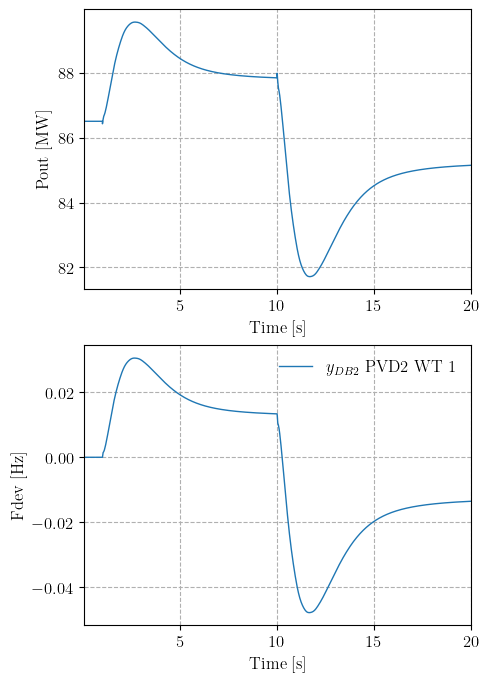

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(5, 8))

sa.TDS.plt.plot_data(sa.dae.ts.t,
                     pe,
                     grid=True,
                     fig=fig, ax=ax[0],
                     ylabel='Pout [MW]',
                     xlabel='Time [s]',
                     show=False)
sa.TDS.plt.plot([sa.PVD2.DB2_y],
                a=(0),
                grid=True,
                fig=fig, ax=ax[1],
                ylabel='Fdev [Hz]',
                show=False,)

In [10]:
sa.PVD2.ddn.v[0]

0.3

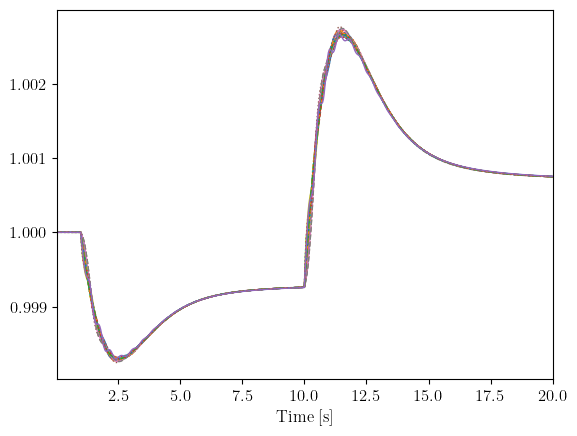

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='Time [s]'>)

In [11]:
sa.TDS.plt.plot(sa.GENROU.omega)